In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import pyccl as ccl
from scipy.optimize import minimize
import emcee
import corner
import astropy.cosmology
import astropy.units as u
from chainconsumer import ChainConsumer
import pickle
import pandas as pd
import sacc
from scipy.stats import norm

# Load data

In [2]:
def load_sacc(filename):
    s = sacc.Sacc.load_fits(filename)
    covariances = []
    df = pd.DataFrame()
    nz_df = pd.DataFrame()
    
    for i in range(5):
        tx = s.get_theta_xi('galaxy_density_xi', f'lens_{i}', f'lens_{i}', return_cov=True)
        df[f'theta_{i}'] = tx[0]
        df[f'w_{i}'] = tx[1]
        df[f'werr_{i}'] = s.get_tag('error', 'galaxy_density_xi', (f'lens_{i}', f'lens_{i}'))
        covariances.append(tx[2])
        
        nz_df[f'z_{i}'] = s.tracers[f'lens_{i}'].z
        nz_df[f'Nz_{i}'] = s.tracers[f'lens_{i}'].nz

    return df, nz_df, covariances

In [3]:
data_vector = load_sacc('TXPipe_sacc/summary_statistics_real.sacc')

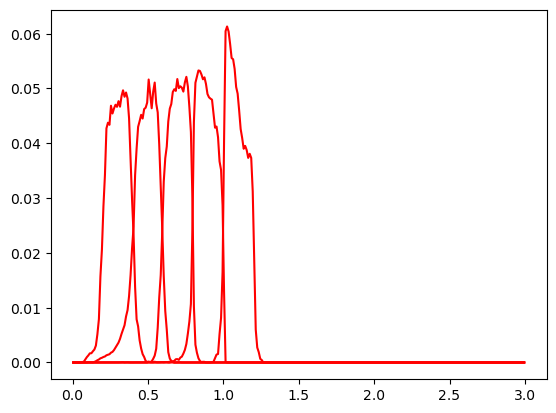

In [4]:
#For example, let's look at the n(z) distribution of the truth data vector
for i in range(5):
    plt.plot(data_vector[1][f"z_{i}"], data_vector[1][f"Nz_{i}"], color='red', label='Gaussian')

# Define Model

In [5]:
#Define model
def model(pars, data, nz_out):
    Omega_m, Omega_b, sigma8, n_s, h, b1, b2, b3, b4, b5 = pars
    b = np.array([b1, b2, b3, b4, b5,])
    cosmo = ccl.Cosmology(Omega_b=Omega_b, Omega_c=Omega_m-Omega_b, n_s=n_s, h=h, sigma8=sigma8)
    tracers = [ccl.NumberCountsTracer(cosmo, True, dndz=(nz_out[f'z_{i}'], nz_out[f'Nz_{i}']),
                                      bias=(nz_out[f'z_{i}'], 
                                            b[i]*np.ones_like(nz_out[f'z_{i}']))) for i in range(5)]
    ell = np.unique(np.geomspace(0.1, 30000, 75).astype(int))
    cls_all = [ccl.angular_cl(cosmo, tracers[i], tracers[i], ell) for i in range(5)]
    corr_func = [ccl.correlation(cosmo, ell, cls_all[i], data[f'theta_{i}']/60) for i in range(5)]
    
    return corr_func

def prior(pars):
    Omega_m, Omega_b, sigma8, n_s, h, b1, b2, b3, b4, b5 = pars
    pr =  norm.pdf(Omega_m-Omega_b, 0.22, 0.2) *\
    norm.pdf(Omega_b, 0.0448, 0.006) *\
    norm.pdf(sigma8, 0.8, 0.14) *\
    norm.pdf(n_s, 0.963, 0.08) *\
    norm.pdf(h, 0.71, 0.063) *\
    norm.pdf(b1, 1.229, 0.9) *\
    norm.pdf(b2, 1.362, 0.9) *\
    norm.pdf(b3, 1.502, 0.9) *\
    norm.pdf(b4, 1.648, 0.9) *\
    norm.pdf(b5, 1.799, 0.9)
    return -0.5 * np.log(pr)

def log_like(pars, data, nz_out, inv_cov, masks):
    pri = prior(pars)
    if np.isfinite(pri):
        w_model = model(pars, data, nz_out)
        resid = [np.einsum('i, ij, j', 
                           data[f'w_{i}'][masks[i]]-w_model[i][masks[i]], 
                           inv_cov[i], 
                           data[f'w_{i}'][masks[i]]-w_model[i][masks[i]]) for i in range(5)]
        resid = -0.5*np.sum(resid)
        return resid + pri
    else:
        return pri

In [6]:
#Test the likelihood function
tarr = [0.265, 0.0448, 0.8, 0.963, 0.71, 1.229, 1.362, 1.502, 1.648, 1.799]
angles = [42.81, 26.93, 20.21, 16.52, 14.21]

data, nz_data, cov = data_vector

masks = [np.where(data[f'theta_{i}'] > angles[i])[0] for i in range(len(angles))]
inv_cov = np.array([np.linalg.inv(cov[i][masks[i][0]:masks[i][-1]+1, 
                                             masks[i][0]:masks[i][-1]+1]) for i in range(5)])

print(log_like(tarr, data, nz_data, inv_cov, masks))

/var/folders/d1/k792r3jx2dnfdzf197jwm17m0000gn/T/ipykernel_33127/3477279258.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  inv_cov = np.array([np.linalg.inv(cov[i][masks[i][0]:masks[i][-1]+1,


-263.653585921989


In [7]:
#We can minimize the function to find the most likely point
def min_func(*args):
    return -1 * log_like(*args)

In [8]:
res = minimize(min_func, tarr, args=(data, nz_data, inv_cov, masks),
              method = 'Nelder-Mead')
print(res)

 final_simplex: (array([[0.2261327 , 0.03422623, 0.62640654, 1.06614381, 0.89587761,
        1.14775682, 1.35737671, 1.62257729, 1.81092315, 2.05714386],
       [0.22613276, 0.03422624, 0.62640664, 1.06614409, 0.89587774,
        1.14775665, 1.35737616, 1.62257709, 1.81092308, 2.05714446],
       [0.22613273, 0.03422622, 0.62640664, 1.06614377, 0.8958778 ,
        1.14775702, 1.3573767 , 1.6225771 , 1.81092301, 2.05714394],
       [0.22613253, 0.03422624, 0.62640664, 1.06614382, 0.89587763,
        1.14775663, 1.35737732, 1.62257741, 1.81092283, 2.05714393],
       [0.22613299, 0.03422621, 0.62640667, 1.06614391, 0.89587726,
        1.14775761, 1.35737634, 1.62257736, 1.81092265, 2.05714363],
       [0.22613241, 0.03422623, 0.62640647, 1.06614381, 0.89587783,
        1.1477565 , 1.35737711, 1.62257743, 1.81092346, 2.0571445 ],
       [0.22613272, 0.03422625, 0.62640678, 1.06614365, 0.895878  ,
        1.14775561, 1.35737681, 1.62257712, 1.81092326, 2.05714396],
       [0.22613283, 0.03

In [9]:
angle_list = angles
def theory_data_plot(data, label, pars, col):
    data_vec, nz_data_vec, cov = data
    
    masks = [np.where(data_vec[f'theta_{i}'] > angle_list[i])[0] for i in range(len(angle_list))]
    inv_cov = np.array([np.linalg.inv(cov[i][masks[i][0]:masks[i][-1]+1, 
                                                     masks[i][0]:masks[i][-1]+1]) for i in range(5)], 
                           dtype='object')
    w_model = model(pars, data_vec, nz_data_vec)
    
    resid = [np.einsum('i, ij, j', 
                       data_vec[f'w_{i}'][masks[i]]-w_model[i][masks[i]], 
                       inv_cov[i], 
                       data_vec[f'w_{i}'][masks[i]]-w_model[i][masks[i]]) for i in range(5)]
    n_dof = [len(data_vec[f'w_{i}'][masks[i]]) for i in range(len(masks))]
    
    #PLOT
    fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 3))
    for i in range(len(axs)):
        axs[i].set_title(f'z = {np.round((.2*i)+.2, 2)} — {np.round((.2*i)+.4, 2)}')

        axs[i].axvspan(0, angle_list[i], alpha=0.2)
        axs[i].errorbar(data_vec[f'theta_{i}'], data_vec[f'w_{i}'], data_vec[f'werr_{i}'], 
                        label=label, color=col)
        axs[i].plot(data_vec[f'theta_{i}'][len(data_vec[f'theta_{i}']) - len(w_model[i]):], w_model[i], 
                    label='CCL', color='red')
        axs[i].set_xscale('log'); axs[i].set_yscale('log')
        axs[i].set_xlim(2, 250)
        axs[i].set_ylim(4e-5, .1)
        axs[i].legend(loc='lower left')
        axs[i].set_xlabel('$\\theta$ [arcmin]')
        axs[i].text(0.95, 0.9, f'$\\chi^2/\\nu$ = {resid[i]:.1f}/{n_dof[i]:.0f}', horizontalalignment='right', 
             verticalalignment='center', transform=axs[i].transAxes)
        if i==0:
            axs[i].set_ylabel('$w(\\theta)$')
    fig.suptitle(f'{label}; pars = {np.round(pars, 2)}; $\\chi^2/\\nu$ = {np.sum(resid):.1f}/{np.sum(n_dof)}', y=1.05)
    fig.subplots_adjust(top=0.85)
    plt.show()

In [10]:
parnames = ['Omega_m', 'Omega_b', 'sigma8', 'n_s', 'h', 'b1', 'b2', 'b3', 'b4', 'b5']
pd.DataFrame({'Parameter':parnames, 'Value':res.x})

,Parameter,Value
0,Omega_m,0.226133
1,Omega_b,0.034226
2,sigma8,0.626407
3,n_s,1.066144
4,h,0.895878
5,b1,1.147757
6,b2,1.357377
7,b3,1.622577
8,b4,1.810923
9,b5,2.057144


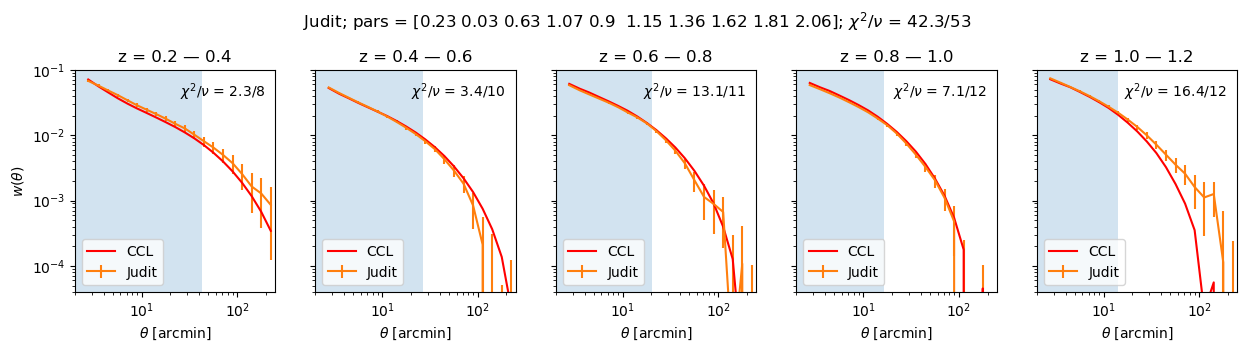

In [11]:
theory_data_plot(data_vector, label='Judit', pars=res.x, col='C1')